# Direct Object Detection from Query

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.ndimage import distance_transform_edt
from astropy.visualization import (MinMaxInterval, ImageNormalize)
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.coordinates import SkyCoord

import sep
sep.set_extract_pixstack(1000000)

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np
from dl import authClient as ac, queryClient as qc
import pandas as pd

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Image Query
Querying a single image from the DESI legacy survey. 

In [24]:
def query_bricks(ra, dec, dist):
    """Queries the Astro Data Lab for brick names and associated RA/DEC based on the given RA/DEC
    
    dist is in degrees
    """
    
    # one RA/DEC pair, then some set range around that?
    ra_max = ra + dist
    ra_min = ra - dist
    dec_max = dec + dist
    dec_min = dec - dist

    query = f"""
    SELECT brickname, ra, dec, mag_g, snr_g, psfdepth_g, psfsize_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g > 0
    AND mag_g <= 21
    AND brickname = '2139p192'
    AND snr_g >= 1
    AND psfdepth_g > 0
    """

    print(query)
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    
    return brick_info

brick_df = query_bricks(213.9167, 19.1822, 0.125)
brick_df


    SELECT brickname, ra, dec, mag_g, snr_g, psfdepth_g, psfsize_g
    FROM ls_dr10.tractor_s
    WHERE ra >= (213.7917) AND ra < (214.0417)
    AND dec >= (19.0572) AND dec < (19.3072)
    AND mag_g > 0
    AND mag_g <= 21
    AND brickname = '2139p192'
    AND snr_g >= 1
    AND psfdepth_g > 0
    
Querying the Astro Data Lab...


,brickname,ra,dec,mag_g,snr_g,psfdepth_g,psfsize_g
0,2139p192,213.862076,19.145645,18.302511,1047.938600,1152.82730,1.056615
1,2139p192,213.871449,19.152371,20.052040,340.506350,1152.82730,1.056615
2,2139p192,213.839823,19.199076,16.691080,1547.278100,513.23303,1.057758
3,2139p192,213.834728,19.169711,18.684044,329.202820,374.87366,1.008856
4,2139p192,213.840518,19.180455,20.873873,96.467670,1085.17500,1.019854
...,...,...,...,...,...,...,...
123,2139p192,213.989185,19.215327,20.892965,81.049194,682.21530,1.584305
124,2139p192,213.994771,19.203625,20.495577,117.902150,682.21530,1.584305
125,2139p192,213.946936,19.304553,20.435204,108.522620,403.33588,1.615114
126,2139p192,213.961128,19.289947,20.620705,107.862080,620.12460,1.615114


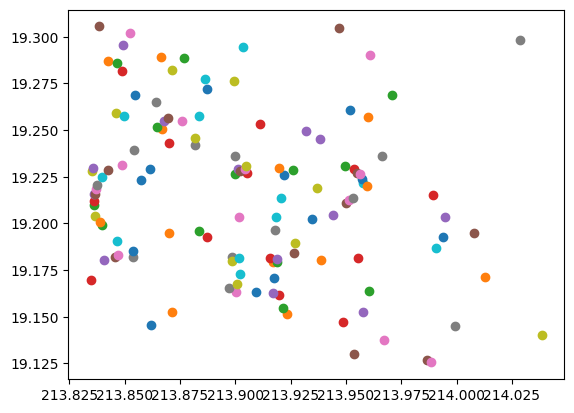

In [23]:
for x, y in zip(brick_df['ra'], brick_df['dec']):
    plt.scatter(x,y)

## Source Extraction
Now that we have our threshold which takes into account our magnitude limit and global background for the image, we can run source extraction from SEP to pull out objects that meet this threshold. Note that the depth of the DESI survey is far greater than the 2.3, so objects may be identified that do not meet the limiting magnitude.

In [22]:
def source_exctract():
    objects = sep.extract(data, thresh, err=sep.Background(data).globalrms, segmentation_map=True)
    bkg_img = objects[0]
    seg_map = objects[1] # the boolean array of light/dark spots is what we need to create the segmentation map.

    return (bkg_img, seg_map)

bkg_image, seg_map = source_exctract()
len(bkg_image)

26

Plot the background-subtracted image, with ellipses around each object that meets the limiting magnitude.

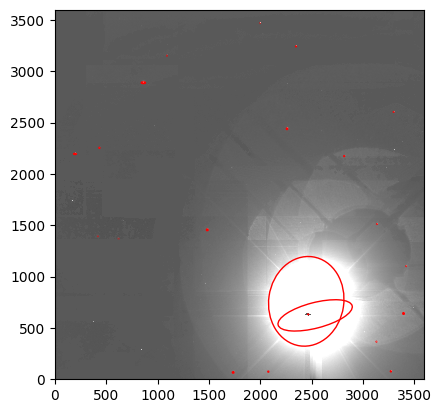

In [23]:
def plot_image():
    """"Plots the image in a modified colour scale with ellipses around detected objects """

    # Plots the image
    fig, ax = plt.subplots()
    m, s = np.mean(data), np.std(data)
    im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

    # plot an ellipse for each object
    for i in range(len(bkg_image)):
        e = Ellipse(xy=(bkg_image['x'][i], bkg_image['y'][i]),
                    width=5*bkg_image['a'][i],
                    height=5*bkg_image['b'][i],
                    angle=bkg_image['theta'][i] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)

    return


plot_image()

Plot segmentation map with axes converted to sky coordinates rather than pixels. 

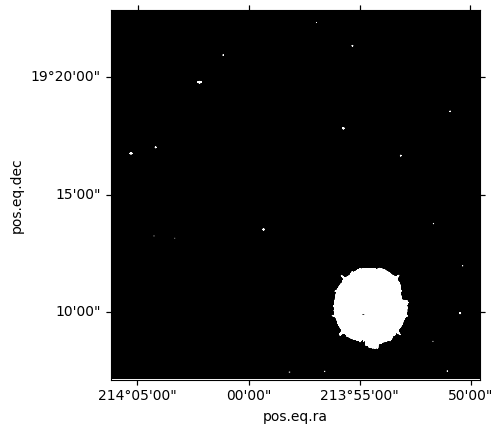

In [24]:
def plot_seg_map():
    """ Plots the segmentation map, given as an output in the source extraction step """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)
    plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')

    return

plot_seg_map()

Manually converting the original image data from pixel flux units (nanomaggies) to magnitudes, then displaying all pixels with magnitudes brighter than 21 shows the same objects as found by the segmentation map

/var/folders/6g/03kjn0jj0f1gfscsfx7_n9l00000gn/T/ipykernel_13623/1872673961.py:3: RuntimeWarning: divide by zero encountered in log10
  return 22.5 - 2.5*np.log10(data)
/var/folders/6g/03kjn0jj0f1gfscsfx7_n9l00000gn/T/ipykernel_13623/1872673961.py:3: RuntimeWarning: invalid value encountered in log10
  return 22.5 - 2.5*np.log10(data)


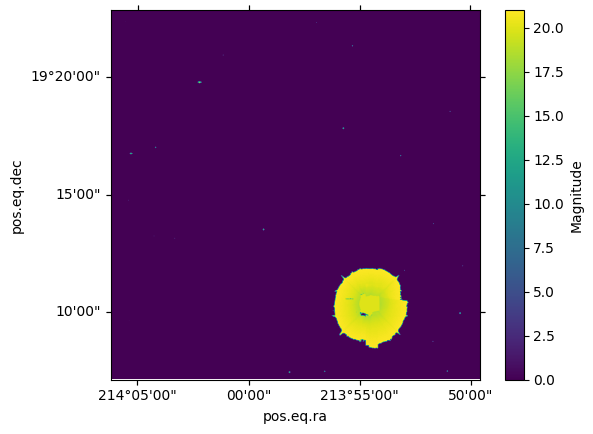

In [25]:
def pix_to_mag(data):
    """Convert pixel values (linear flux) to magnitudes for data with a zero point of 22.5"""
    return 22.5 - 2.5*np.log10(data)

# convert pixels to magnitudes
data_magnitude = pix_to_mag(data)
bright_data = np.zeros_like(data_magnitude)
for i, row in enumerate(data_magnitude):
    bright_data[i] = [pix if pix <= 21 else 0 for pix in row]


fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
plt.imshow(bright_data, origin='lower')
plt.colorbar(ax=ax, label="Magnitude")


## Finding Dark Regions
Now expand the exclusion zones to a 20 arcsec radius around each object. The centre of the 2.3 FOV cannot be within these exclusion zones. We also add a grid with 45 arcsec diameter squares to demonstrate all the potential centres of the 2.3m FOV.

In [26]:
def exclusion_zones(pixscale=0.262, exclude_radius = 20):
    """"""

    # Calculate the distance transform of the seg_map
    distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

    # Expand seg_map for exclusion zones
    excl_map = np.copy(seg_map)
    excl_map[distance <= exclude_radius] = 1

    return excl_map, pixscale

excl_map, pixscale = exclusion_zones()

def define_grid(fov=45):
    
    gridscale = fov//float(exclusion_zones()[1])
    gridlines = np.arange(0,3600,gridscale)
    gridlines = gridlines.astype(int)

    return gridlines

gridlines = define_grid()

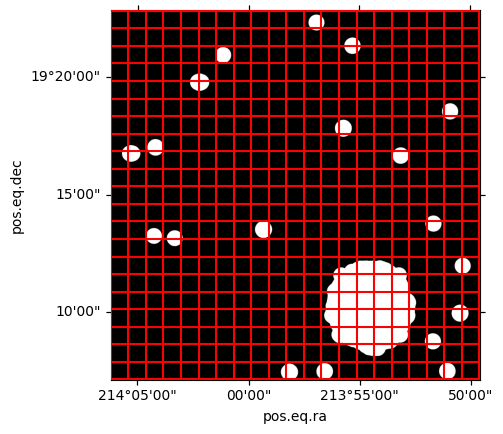

In [27]:
def create_grid():

    # Creating exclusion map with grid
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

    norm = ImageNormalize(excl_map, MinMaxInterval())
    plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
    plt.vlines(gridlines,0,3600,colors='red')
    plt.hlines(gridlines,0,3600,colors='red')
    plt.margins(0)
    plt.show()

    return

create_grid()

The final step is to find the centre coordinate of every single grid square that does not have any exclusion zone in it. In this case, it is all squares except the bottom left corner. We locate these centres and plot an 'x' on each RADEC coordinate for dark sky regions.

In [28]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = gridlines[i], gridlines[i + 1]
            y_start, y_end = gridlines[j], gridlines[j + 1]
            
            if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

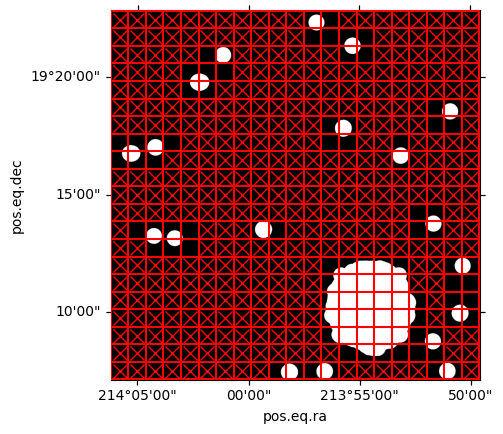

In [29]:
def plot_dark_regions():
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

    norm = ImageNormalize(excl_map, MinMaxInterval())
    plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
    plt.vlines(gridlines,0,3600,colors='red')
    plt.hlines(gridlines,0,3600,colors='red')
    plt.margins(0)
    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)
    plt.show()

    return

plot_dark_regions()

In [30]:
def dr_dataframe():

    # list of dark sky coords
    dark_x = []
    dark_y = []

    for i in range(len(dr_trans[0])):
        dark_x.append(dr_trans[1][i]*pixscale + ra)
        dark_y.append(dr_trans[0][i]*pixscale + dec)

    dark_coords = [dark_x, dark_y]

    ra_coords = []
    dec_coords = []

    c = SkyCoord(ra=dark_coords[0], dec=dark_coords[1], unit='arcsec')
    for i in range(len(c)):
        ra_coords.append(c[i].ra.degree)
        dec_coords.append(c[i].dec.degree)

    # create a data frame of coords list
    d = {'RA':ra_coords, 'DEC':dec_coords}
    df = pd.DataFrame(data=d)
    
    return df

df = dr_dataframe()

df
len(df)

347